In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Preprocessing and Visualisation

In [269]:
df = pd.read_csv("clean-dirty-metadata.csv",sep=';')
df = df.drop(['source','x_lat','y_lon','annotation_path'],axis=1)
df["label"] = (df["label"] == "clean").astype(int)
df

,image_path,split,label
0,clean-dirty-garbage-containers/train/clean/001...,train,1
1,clean-dirty-garbage-containers/train/clean/001...,train,1
2,clean-dirty-garbage-containers/train/clean/001...,train,1
3,clean-dirty-garbage-containers/train/clean/001...,train,1
4,clean-dirty-garbage-containers/train/clean/001...,train,1
...,...,...,...
3407,clean-dirty-garbage-containers/test/dirty/e8e1...,test,0
3408,clean-dirty-garbage-containers/test/dirty/f02b...,test,0
3409,clean-dirty-garbage-containers/test/dirty/f29b...,test,0
3410,clean-dirty-garbage-containers/test/dirty/fc02...,test,0


In [270]:
IMG_WIDTH=32
IMG_HEIGHT=32

#get pathname and convert the image into the right shape
df["images"]=""
for i in range(len(df)) :
    im = cv2.imread(df["image_path"][i].partition("/")[2], cv2.COLOR_BGR2GRAY)
    image = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH))
    image = np.array(image)
    image = image.astype('float32')
    image /= 255 
    df["images"][i]=image.astype(float)
    

In [271]:
'''# to have a smaller dataset to work with
from sklearn.utils import shuffle
df = shuffle(df)
df1 = df[:200]
df1
'''
# split into train and test
df_train = df[df.split == 'train']
df_test = df[df.split == 'test']

#keep interesting column
train_df = df_train.drop(['image_path','split'],axis=1)
test_df = df_test.drop(['image_path','split'],axis=1)

<AxesSubplot:ylabel='count'>

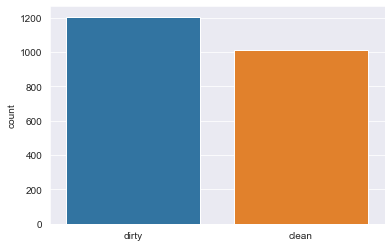

In [272]:
#visualisation to see if my dataset is balance
l = []
for i in df_train.label:
    if(i == 0):
        l.append("clean")
    else:
        l.append("dirty")
sns.set_style('darkgrid')
sns.countplot(l)

In [317]:
#Convert the target arrays to one-hot encodings
'''from keras.utils.np_utils import to_categorical
y_train = tf.keras.utils.to_categorical(
    train_df['label'], num_classes=None, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    test_df['label'], num_classes=None, dtype='float32'
)'''
#one or the other I test
y_train = np.asarray(train_df['label']).astype('float32').reshape((-1,1))
y_test = np.asarray(test_df['label']).astype('float32').reshape((-1,1))

In [318]:
#convert to numpy array 
#!!! suppose to be the same for test but there is a bug and I will deal with it later(tired!!)
train = []
for i in range(len(train_df)):
    train.append(train_df['images'][i])
train = np.array(train)

test = []
for index, row in test_df.iterrows():
    test.append(row['images'])
test_ = np.array(test)

In [275]:
x_train = train
x_test = test_

In [319]:
print("Shape of training data", x_train.shape)
print("\nShape of test data", x_test.shape)

Shape of training data (2217, 32, 32, 3)

Shape of test data (1195, 32, 32, 3)


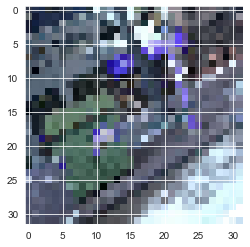

In [320]:
plt.imshow(x_train[630]) #example

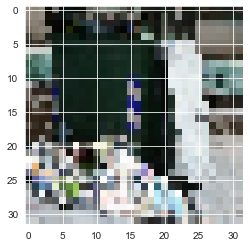

In [321]:
plt.imshow(x_test[601]) #example

## First Naive model

In [336]:
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 64)        

In [339]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=8)

history = model.fit(
    x_train,
    y_train_,
    batch_size=32,
    epochs=10,
    validation_data=(0.1*x_train, 0.1*y_train_),callbacks=es
)

Epoch 1/10
70/70 [==============================] - 1s 17ms/step - loss: 0.4774 - accuracy: 0.7740 - val_loss: 0.7936 - val_accuracy: 0.0550
Epoch 2/10
70/70 [==============================] - 1s 17ms/step - loss: 0.4400 - accuracy: 0.8020 - val_loss: 0.9111 - val_accuracy: 0.0041
Epoch 3/10
70/70 [==============================] - 1s 18ms/step - loss: 0.4139 - accuracy: 0.8146 - val_loss: 0.9401 - val_accuracy: 9.0212e-04
Epoch 4/10
70/70 [==============================] - 1s 19ms/step - loss: 0.3941 - accuracy: 0.8232 - val_loss: 1.0061 - val_accuracy: 0.0000e+00
Epoch 5/10
70/70 [==============================] - 1s 19ms/step - loss: 0.3468 - accuracy: 0.8557 - val_loss: 1.1038 - val_accuracy: 0.0000e+00
Epoch 6/10
70/70 [==============================] - 1s 19ms/step - loss: 0.3152 - accuracy: 0.8719 - val_loss: 0.9795 - val_accuracy: 4.5106e-04
Epoch 7/10
70/70 [==============================] - 1s 17ms/step - loss: 0.2735 - accuracy: 0.8908 - val_loss: 0.9432 - val_accuracy: 0.00

## Predictions

In [341]:
predictions = model.predict(x_test)
print(predictions)

[[0.06826773]
 [0.710962  ]
 [0.50240505]
 ...
 [0.12966633]
 [0.05464759]
 [0.13052526]]


clean street by [93.2] % [0.068]


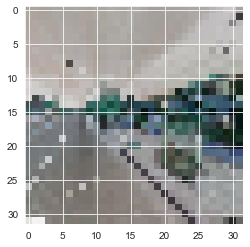

In [381]:
plt.imshow(x_test[0])
pred = np.round(predictions[0],decimals=3)
print('clean street by', np.abs(100 - 100*pred),'%',pred)

clean street by [16.599998] % [0.834]


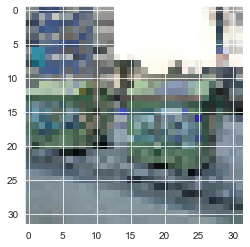

In [382]:
plt.imshow(x_test[130])
pred = np.round(predictions[130],decimals=3)
print('clean street by', np.abs(100 - 100*pred),'%',pred)

## Evaluation the result

In [ ]:
#to be fulfill....